# Discrete Choice Modeling

For more detailed information, please see: 

Koppelman & Bhat (2006) A Self-Instructing Course in Mode Choice Modeling
http://www.caee.utexas.edu/prof/bhat/COURSES/LM_Draft_060131Final-060630.pdf 


### Motivation

Not everything has a continous dependent variable.  Some things are discrete.  Coke or Pepsi?  Soda or pop?  Let's think of a few...

Discrete choice models give us a way to model this.  


### Elements

In this framework, there are several elements to the choice decision process: 

- The decision maker
- The alternatives
- Attributes of the alternatives
- The decision rule


### Structure and Assumptions

We will use a multi-nomial logit (MNL) model.  It takes the form: 

$Pr(i) = \frac{e^{U_i}}{\sum_{j=1}^{J} e^{U_j}}$

where $U_i = \beta X_i + \epsilon_i$ and $\epsilon_i$ follows a Gumbel distribution. 

This equation defines the decision rule.  A bit of time to work it through...

### Libraries

Will be using [Statsmodels](http://statsmodels.sourceforge.net/).  Start with: 

    conda install statsmodels
    
    

### Today's objective

Today, we want to predict vehicle ownership.  

We'll be using the PUMS data again.  This time we'll use the household records instead of the person records, and households will be our decision-making unit.  You can find the data here: 

https://www.census.gov/programs-surveys/acs/data/pums.html

Please download the Kentucky 1-year household data.  

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf

# this allows plots to appear directly in the notebook
%matplotlib inline

In [2]:
# get the data
df = pd.read_csv('data/ss15hky.csv')
df.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,wgtp71,wgtp72,wgtp73,wgtp74,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80
0,H,4,6,100,3,21,1000000,1001264,112,2,...,84,112,44,156,157,164,162,22,118,88
1,H,39,6,1706,3,21,1000000,1001264,58,7,...,58,95,16,16,17,18,93,57,61,62
2,H,116,6,1400,3,21,1000000,1001264,52,4,...,62,88,54,111,14,13,54,35,54,73
3,H,121,6,800,3,21,1000000,1001264,97,7,...,176,135,94,83,128,120,25,28,37,152
4,H,250,6,2800,3,21,1000000,1001264,0,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# keep only occupied housing units
'''
NP 2
Number of person records following this housing record
00 .Vacant unit
01 .One person record (one person in household or any person in
.group quarters)
02..20 .Number of person records (number of persons in household)

TYPE 1
Type of unit
1 .Housing unit
2 .Institutional group quarters
3 .Noninstitutional group quarters
'''

df = df[df['TYPE']==1]
df = df[df['NP']>0]
len(df)

18055

### Look at the data

It is often a good idea to look at the data we want to model, and see how it relates to some variables we expect to be important.  We can do this using seaborn, which we learned about a few weeks ago.  

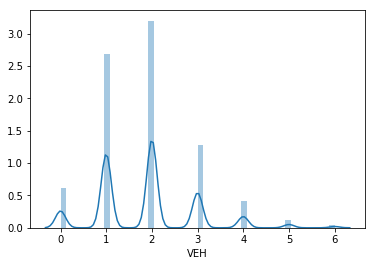

In [4]:
'''
10
VEH 1
Vehicles (1 ton or less) available
b .N/A (GQ/vacant)
0 .No vehicles
1 .1 vehicle
2 .2 vehicles
3 .3 vehicles
4 .4 vehicles
5 .5 vehicles
6 .6 or more vehicles
'''

sns.distplot(df['VEH'])

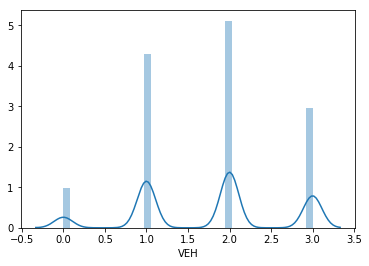

In [5]:
# there aren't very many above 3, so group all of those
df['VEH'] = df['VEH'].apply(lambda x : min(x, 3))
df['VEH'] = df['VEH'].astype(int)

sns.distplot(df['VEH'])

### Estimating a model

OK, that's fine, we can do plots, but we want some actual numbers.  For this, we want to estimate what the model coefficients are. 

In [6]:
# Here is the constants only model. 
mod = smf.MNLogit.from_formula(formula='VEH ~ 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.257492
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                18055
Model:                        MNLogit   Df Residuals:                    18052
Method:                           MLE   Df Model:                            0
Date:                Mon, 07 May 2018   Pseudo R-squ.:                   0.000
Time:                        14:18:12   Log-Likelihood:                -22704.
converged:                       True   LL-Null:                       -22704.
                                        LLR p-value:                       nan
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4814      0.030     48.584      0.000       1.422       1.541
-----------------------------

Notice a few things: 

1. Goodness of fit measures
2. Separate coefficients for each alternative

In [7]:
# That's fine, but we may try some more things.  Perhaps age matters. 
# More people -> more cars? 

mod = smf.MNLogit.from_formula(formula='VEH ~ NP + 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.156405
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                18055
Model:                        MNLogit   Df Residuals:                    18049
Method:                           MLE   Df Model:                            3
Date:                Mon, 07 May 2018   Pseudo R-squ.:                 0.08039
Time:                        14:18:15   Log-Likelihood:                -20879.
converged:                       True   LL-Null:                       -22704.
                                        LLR p-value:                     0.000
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3608      0.071     19.120      0.000       1.221       1.500
NP             0.0709      0.

We can apply this model

### Categorical variables

We may also want to include categorical variables.  We can include them by calculating a 'dummy' variable, which is 1 if the value is in a category, and zero otherwise.  

In [8]:
'''
HUPAC 1
HH presence and age of children
b .N/A (GQ/vacant)
1 .With children under 6 years only
2 .With children 6 to 17 years only
3 .With children under 6 years and 6 to 17 years
4 .No children
'''

dummies = pd.get_dummies(df['HUPAC'])
dummies.columns = ['kids_u6', 'kids_6_17', 'kids_u6_and_617', 'no_kids']
df = df.join(dummies)
df.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80,kids_u6,kids_6_17,kids_u6_and_617,no_kids
0,H,4,6,100,3,21,1000000,1001264,112,2,...,157,164,162,22,118,88,0,0,0,1
1,H,39,6,1706,3,21,1000000,1001264,58,7,...,17,18,93,57,61,62,0,0,1,0
2,H,116,6,1400,3,21,1000000,1001264,52,4,...,14,13,54,35,54,73,0,1,0,0
3,H,121,6,800,3,21,1000000,1001264,97,7,...,128,120,25,28,37,152,0,0,1,0
5,H,260,6,2400,3,21,1000000,1001264,157,2,...,239,241,144,39,164,53,0,1,0,0


In [9]:
# That's fine, but we may try some more things.  Perhaps age matters. 
# More people -> more cars? 

mod = smf.MNLogit.from_formula(formula='VEH ~ NP + kids_u6 + kids_6_17 + kids_u6_and_617 + 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.111589
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                18055
Model:                        MNLogit   Df Residuals:                    18040
Method:                           MLE   Df Model:                           12
Date:                Mon, 07 May 2018   Pseudo R-squ.:                  0.1160
Time:                        14:18:21   Log-Likelihood:                -20070.
converged:                       True   LL-Null:                       -22704.
                                        LLR p-value:                     0.000
          VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.4416      0.083     17.306      0.000       1.278       1.605
NP            

In [ ]:
# what else should we add? 

### Homework

Calculate the probability that a 1-person household in Lexington, earning $16,000 per year owns 0, 1, 2 or 3+ vehicles.  

In [10]:
mod = smf.MNLogit.from_formula(formula='VEH ~ NP + FINCP + 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.060257
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                12004
Model:                        MNLogit   Df Residuals:                    11995
Method:                           MLE   Df Model:                            6
Date:                Mon, 07 May 2018   Pseudo R-squ.:                 0.07491
Time:                        14:18:40   Log-Likelihood:                -12727.
converged:                       True   LL-Null:                       -13758.
                                        LLR p-value:                     0.000
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8321      0.157     11.655      0.000       1.524       2.140
NP            -0.1764      0.

In [12]:
df = df[df['ST'] == 21] #state code 21
df.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80,kids_u6,kids_6_17,kids_u6_and_617,no_kids
0,H,4,6,100,3,21,1000000,1001264,112,2,...,157,164,162,22,118,88,0,0,0,1
1,H,39,6,1706,3,21,1000000,1001264,58,7,...,17,18,93,57,61,62,0,0,1,0
2,H,116,6,1400,3,21,1000000,1001264,52,4,...,14,13,54,35,54,73,0,1,0,0
3,H,121,6,800,3,21,1000000,1001264,97,7,...,128,120,25,28,37,152,0,0,1,0
5,H,260,6,2400,3,21,1000000,1001264,157,2,...,239,241,144,39,164,53,0,1,0,0


In [13]:
df = df[df['PUMA'].isin([1901,1902])] #Lexington PUMAs
df.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80,kids_u6,kids_6_17,kids_u6_and_617,no_kids
9,H,445,6,1902,3,21,1000000,1001264,68,2,...,70,65,125,77,67,63,0,0,0,1
13,H,730,6,1901,3,21,1000000,1001264,62,1,...,18,60,123,62,59,16,0,0,0,1
21,H,1017,6,1902,3,21,1000000,1001264,72,2,...,20,128,84,18,117,69,0,0,0,1
38,H,2121,6,1901,3,21,1000000,1001264,70,2,...,71,123,59,21,66,176,0,0,0,1
75,H,4611,6,1901,3,21,1000000,1001264,48,1,...,43,13,52,49,45,39,0,0,0,1


In [17]:
mod = smf.MNLogit.from_formula(formula='VEH ~ NP + FINCP + 1', data=df)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.950200
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:                    VEH   No. Observations:                  756
Model:                        MNLogit   Df Residuals:                      747
Method:                           MLE   Df Model:                            6
Date:                Mon, 07 May 2018   Pseudo R-squ.:                  0.1238
Time:                        14:22:34   Log-Likelihood:                -718.35
converged:                       True   LL-Null:                       -819.88
                                        LLR p-value:                 4.241e-41
     VEH=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2003      0.678      0.295      0.768      -1.129       1.529
NP             0.1258      0

Utility to Own 0 Vehicles
U0 = 0

Utility to Own 1 Vehicle
U1 = 0.2003 +.0613(NP)+3.319*10^-5(FINCP)


Utility to Own 2 Vehicles
U2 = 0.1854 +.1258(NP)+4.987e-05(FINCP)

Utility to Own 3 Vehicles
U1 = -2.8273 +0.5777(NP)+5.299e-05(FINCP)

Probability to Own 0 Vehicle
P0 =0.15516

Probability to Own 1 Vehicle
P1 = 0.3656

Probability to Own 2 Vehicles
P2 = 0.44

Probability to Own 3 Vehicles¶
P3 = 0.0382